# Importig Important Libraries

In [81]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
from skimage import data
from skimage.color import rgb2hed, hed2rgb
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [71]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [82]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    s = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(s)
    return s, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    """ Input layer """
    inputs = Input(input_shape)

    """ Encoder """
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    """ Bottleneck """
    b1 = conv_block(p4, 1024)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    """ Output layer """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

if __name__ == "__main__":
    model = build_unet((256, 256, 3))
    model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_190 (Conv2D)         (None, 256, 256, 64)         1792      ['input_11[0][0]']            
                                                                                                  
 batch_normalization_180 (B  (None, 256, 256, 64)         256       ['conv2d_190[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_180 (Activation  (None, 256, 256, 64)         0         ['batch_normalization_180[0

# Load the images

In [83]:
image_dir = "/content/drive/MyDrive/H&E dataset/IMAGES"
mask_dir = "/content/drive/MyDrive/H&E dataset/MASK"

# Load list of image and mask filenames
image_filenames = os.listdir(image_dir)
mask_filenames = os.listdir(mask_dir)

# Sort the filenames to ensure correspondence between images and masks
image_filenames.sort()
mask_filenames.sort()

# Image Preprocessing
1. Resize the image and mask to (256,256)
2. Convert the colour image to a grayscale image.
3. Pixel normalisation by dividing the pixel value with 255.0

In [84]:
 # Load and preprocess data
x_data = []
y_data = []
for img_filename, mask_filename in zip(image_filenames, mask_filenames):
  img = tf.keras.preprocessing.image.load_img(os.path.join(image_dir, img_filename), target_size=(256, 256),color_mode="grayscale")
  mask = tf.keras.preprocessing.image.load_img(os.path.join(mask_dir, mask_filename), target_size=(256, 256), color_mode="grayscale")

  img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
  mask = tf.keras.preprocessing.image.img_to_array(mask) / 255.0

  x_data.append(img)
  y_data.append(mask)

In [85]:
#convert the image list to array
x_data = np.array(x_data)
y_data = np.array(y_data)

# Builing and training the model

In [86]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.2, random_state = 42)

In [87]:
#building the model using build_unet function
model = build_unet((256,256,1))
model.compile(optimizer = 'adam', loss = BinaryCrossentropy(), metrics = ['accuracy'])

#define the early stopping
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 5, restore_best_weights = True)

#training the model
r = model.fit(x_train, y_train,
              batch_size = 8,
              epochs = 25,
              validation_data =(x_test,y_test),
              )

Epoch 1/25
5/5 [==============================] - 19s 1s/step - loss: 0.7834 - accuracy: 0.4770 - val_loss: 0.6731 - val_accuracy: 0.8873
Epoch 2/25
5/5 [==============================] - 3s 565ms/step - loss: 0.5216 - accuracy: 0.8313 - val_loss: 0.8868 - val_accuracy: 0.1511
Epoch 3/25
5/5 [==============================] - 3s 545ms/step - loss: 0.3995 - accuracy: 0.8856 - val_loss: 1.4693 - val_accuracy: 0.3647
Epoch 4/25
5/5 [==============================] - 3s 573ms/step - loss: 0.3712 - accuracy: 0.8856 - val_loss: 184.2813 - val_accuracy: 0.1199
Epoch 5/25
5/5 [==============================] - 3s 576ms/step - loss: 0.3663 - accuracy: 0.8821 - val_loss: 20.1134 - val_accuracy: 0.6787
Epoch 6/25
5/5 [==============================] - 3s 548ms/step - loss: 0.3661 - accuracy: 0.8863 - val_loss: 264.8031 - val_accuracy: 0.1205
Epoch 7/25
5/5 [==============================] - 3s 551ms/step - loss: 0.3558 - accuracy: 0.8848 - val_loss: 50.5993 - val_accuracy: 0.1498
Epoch 8/25
5/5 [

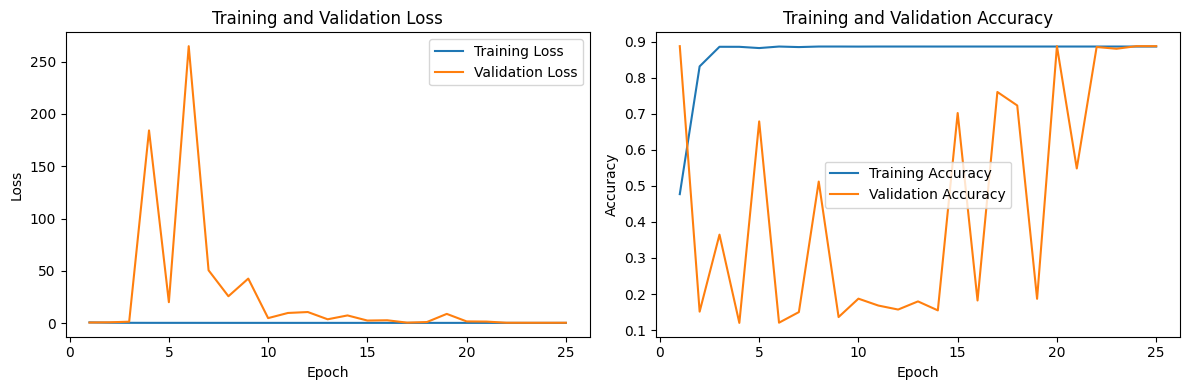

In [88]:
#Extract training history
train_loss = r.history['loss']
val_loss = r.history['val_loss']
train_accuracy = r.history['accuracy']
val_accuracy = r.history['val_accuracy']

# Plot the training curve
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Model Evaluation

In [89]:
# Evaluate the model on the test dataset
evaluation = model.evaluate(x_test, y_test)

# Print the evaluation results
print("Test Loss:", evaluation[0])
print("Test Accuracy:", evaluation[1])

1/1 [==============================] - 0s 264ms/step - loss: 0.4637 - accuracy: 0.8873
Test Loss: 0.4636996388435364
Test Accuracy: 0.887347400188446


In [90]:
model.save('unet_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
